In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics, preprocessing
import csv
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

#filename = "cdf_score999.csv"
filename = "Crispr_Data.csv"
Scores = pd.read_csv(filename)
CCTop = Scores["CCTopSores"]
Cropit = Scores["CropitScores"]
MIT = Scores["MITscores"]
MITWeb = Scores["MITwebsite"]
CFD = Scores["cfdScore"]
Label = Scores["label"]
phastCons = Scores["scores"]
phastCons = phastCons.where(phastCons.notnull(), 0)
phylop = Scores["phylop"]
phylop = phylop.where(phylop.notnull(), 0)
Promoter = Scores["Promoter"]
Enhancer = Scores["Enhancer"]
segwayPromoter = Scores["segwayPromoter"]
segwayEnhancer = Scores["segwayEnhancer"]

#normsocres = np.transpose(np.vstack((MITWeb, MIT, CCTop, Cropit, CFD, 
                                     #phylop, phastCons, Promoter, Enhancer, segwayPromoter, segwayEnhancer)))

normsocres = np.transpose(np.vstack((MITWeb, MIT, CCTop, Cropit, CFD, 
                                     phylop, phastCons)))
X_train, X_test, y_train, y_test = train_test_split(normsocres, Label, test_size=0.2, random_state=42)

bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=200)
rf = RandomForestClassifier(max_depth=1, n_estimators=200)
svc = SVC(kernel = "rbf")
svc1 = SVC(kernel = "sigmoid")

dt = DecisionTreeClassifier(max_depth=6)
mlp = MLPClassifier(alpha=1, activation="relu")
cv = StratifiedKFold(n_splits=5)


In [7]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
print 1

i = 0
plt.figure(figsize=(7, 7))  
sub_normsocres = normsocres[:,(0,1,2,3,4,5,6)]
#MITWeb, MIT, CCTop, Cropit, CFD, phylop, phastCons

print 2

for train, test in cv.split(sub_normsocres, Label):
    
    #AdaBoost
    scores = bdt.fit(sub_normsocres[train], Label[train]).decision_function(sub_normsocres[test])
    #DecisionTree
    #scores = dt.fit(sub_normsocres[train], Label[train]).predict_proba(sub_normsocres[test])[:, 1]
    #RandomForest
    #scores = rf.fit(sub_normsocres[train], Label[train]).predict_proba(sub_normsocres[test])[:, 1]
    
    #scores = svc.fit(sub_normsocres[train], Label[train]).decision_function(sub_normsocres[test])
    #scores = svc1.fit(sub_normsocres[train], Label[train]).decision_function(sub_normsocres[test])
    
    #scores = mlp.fit(sub_normsocres[train], Label[train]).predict_proba(sub_normsocres[test])[:, 1]
    
    print 3
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(Label[test], scores)
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    print roc_auc
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.4f)' % (i, roc_auc))
    i += 1



1
2
3
0.913067846986
3
0.956205641959
3
0.919069367223
3
0.98068903892
3
0.926714323537


In [ ]:
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.4f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC based on RandomForestClassifier')
plt.legend(loc="lower right")
outfname = "Allinall_RF.png"
plt.savefig(outfname, bbox_inches='tight')
print 5


In [ ]:
#plt.show()
#meanMLP = mean_tpr
#meanaucMLP = mean_auc

In [35]:
meanaucAda = mean_auc
mean_fpr_Ada = mean_fpr
mean_tpr_Ada = mean_tpr

In [37]:
meanaucRF = mean_auc
mean_fpr_RF = mean_fpr
mean_tpr_RF = mean_tpr

In [33]:
meanaucDT = mean_auc
mean_fpr_DT = mean_fpr
mean_tpr_DT = mean_tpr

In [38]:
plt.figure(figsize=(7, 7)) 
LabelAda = "Adaboost, AUC %.4f" % meanaucAda
LabelRF = "RandomForest, AUC %.4f" % meanaucRF
LabelDT = "DecisionTree, AUC %.4f" % meanaucDT
#LabelSVC = "SVC, AUC %.4f" % meanaucsvc
#LabelMLP = "MLP, AUC %.4f" % meanaucMLP

plt.plot(mean_fpr_Ada, mean_tpr_Ada, color='r', label= LabelAda, ls = "--", marker ='*')
#plt.plot(mean_fpr, meanMLP, color='grey', label= LabelMLP, ls = ":")
plt.plot(mean_fpr_RF, mean_tpr_RF, color='darkblue', label= LabelRF, ls = "--")
plt.plot(mean_fpr_DT, mean_tpr_DT, color='green', label= LabelDT, ls = "-.")
#plt.plot(mean_fpr, meansvc, color='b', label= LabelSVC, ls = ":", marker ='.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Comparison')
plt.legend(loc="lower right")
outfname = "other classifiers.png"
plt.savefig(outfname, bbox_inches='tight')
plt.clf()
#plt.show()

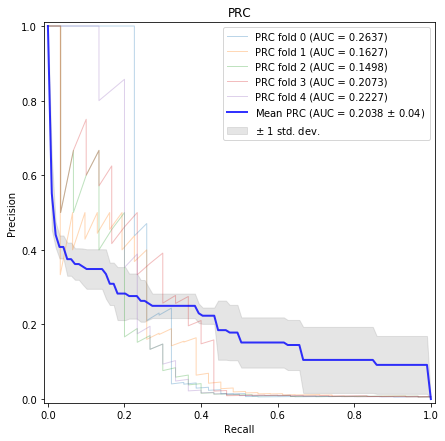

In [139]:
prcs = []
aucs = []
mean_rec = np.linspace(0, 1, 100)
i = 0
plt.figure(figsize=(7, 7))  
sub_normsocres = normsocres
for train, test in cv.split(sub_normsocres, Label):
    
    scores = bdt.fit(sub_normsocres[train], Label[train]).decision_function(sub_normsocres[test])
    #scores = svc.fit(sub_normsocres[train], Label[train]).decision_function(sub_normsocres[test])
    #scores = svc1.fit(sub_normsocres[train], Label[train]).decision_function(sub_normsocres[test])
    #scores = dt.fit(sub_normsocres[train], Label[train]).predict_proba(sub_normsocres[test])[:, 1]
    #scores = rf.fit(sub_normsocres[train], Label[train]).predict_proba(sub_normsocres[test])[:, 1]
    #scores = mlp.fit(sub_normsocres[train], Label[train]).predict_proba(sub_normsocres[test])[:, 1]
    
    # Compute PRC curve and area the curve
    prc, rec, _ = precision_recall_curve(Label[test], scores)
    prcs.append(interp(mean_rec, prc, rec))
    prcs[-1][0] = 1.0
    prc_auc = auc(rec, prc)
    aucs.append(prc_auc)
    plt.plot(rec, prc, lw=1, alpha=0.3,
             label='PRC fold %d (AUC = %0.4f)' % (i, prc_auc))
    i += 1

print(prcs)
mean_prc = np.mean(prcs, axis=0)
mean_prc[-1] = 0.0
mean_auc = auc(mean_rec, mean_prc)
std_auc = np.std(aucs)
plt.plot(mean_rec, mean_prc, color='b',
         label=r'Mean PRC (AUC = %0.4f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_prc = np.std(prcs, axis=0)
prcs_upper = np.minimum(mean_prc + std_prc, 1)
prcs_lower = np.maximum(mean_prc - std_prc, 0)
#print(prcs_upper)
#print(prcs_lower)
plt.fill_between(mean_rec, prcs_lower, prcs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PRC')
plt.legend(loc="upper right")
outfname = "svcPRCwith PhyloP.png"
#outfname = "PRC 14.png"
plt.savefig(outfname, bbox_inches='tight')
plt.clf()

In [ ]:
#plt.show()

meansvc = mean_prc
meanaucsvc = mean_auc

In [1]:
plt.figure(figsize=(7, 7)) 
LabelAda = "AdaBoost, AUC %.4f" % meanaucAda
LabelRF = "RandomForest, AUC %.4f" % meanaucRF
LabelDT = "DecisionTree, AUC %.4f" % meanaucDT
LabelSVC = "SVC, AUC %.4f" % meanaucsvc
LabelMLP = "MLP, AUC %.4f" % meanaucMLP

plt.plot(mean_rec, meanAda, color='r', label= LabelAda, ls = "--", marker ='*')
plt.plot(mean_rec, meanMLP, color='grey', label= LabelMLP, ls = ":")
plt.plot(mean_rec, meanRF, color='darkblue', label= LabelRF, ls = "--")
plt.plot(mean_rec, meanDT, color='green', label= LabelDT, ls = "-.")
plt.plot(mean_rec, meansvc, color='b', label= LabelSVC, ls = ":", marker ='.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PRC')
plt.legend(loc="upper right")
outfname = "PRC other classifiers.png"
plt.savefig(outfname, bbox_inches='tight')
plt.show()

NameError: name 'plt' is not defined